In [1]:
import sys
import json
import os
import numpy as np
import joblib
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def create_dir(name):
    directory = os.path.dirname(name)
    if not os.path.exists(name):
        os.makedirs(name)

In [4]:
def tune_parameters_regression(dataset_name, alg='sgb', n_splits=1):

    # load and prepare data
    data_dir = os.path.join('datasets', dataset_name)
    train_file = os.path.join(data_dir, 'train')
    validation_file = os.path.join(data_dir, 'validation')
    cd_file = os.path.join(data_dir, 'pool.cd')
    
    train_pool = Pool(data=train_file, column_description=cd_file)
    validation_pool = Pool(data=validation_file, column_description=cd_file)
    

    params = []
    seed = 1000 # starting random seed for hyperparameter tuning
    
    for fold in range(n_splits):
    
        # list of hyperparameters for grid search
        depths = [3, 4, 5, 6] # tree depth
        lrs = [0.001, 0.01, 0.1] # learning rate 
        if alg == "sgb" or alg == "sglb": # by default, we tune sample rate
            samples = [0.25, 0.5, 0.75]
        if alg == "sgb-fixed": # sgb without sample rate tuning
            samples = [0.5]
        if alg == "sglb-fixed": # sglb without sample rate tuning
            samples = [1.0]
        shape = (len(depths), len(lrs), len(samples))

        results = np.zeros(shape)
        
        # perform grid search
        for d, depth in enumerate(depths):
            for l, lr in enumerate(lrs):
                for s, sample in enumerate(samples):
                    if alg == 'sgb' or alg == 'sgb-fixed':
                            model = CatBoostRegressor(loss_function='RMSEWithUncertainty',
                                                      learning_rate=lr, depth=depth, 
                                                      subsample=sample, bootstrap_type='Bernoulli', verbose=False, 
                                                      random_seed=seed)                      
                    if alg == 'sglb' or alg == 'sglb-fixed':
                        model = CatBoostRegressor(loss_function='RMSEWithUncertainty',
                                                  learning_rate=lr, depth=depth, 
                                                  subsample=sample, 
                                                  bootstrap_type='Bernoulli', 
                                                  verbose=False, random_seed=seed, posterior_sampling=True,
                                                 allow_writing_files=False)

                    model.fit(train_pool, eval_set=validation_pool, use_best_model=False)

                # compute nll
                results[d, l, s] = model.evals_result_['validation']['RMSEWithUncertainty'][-1]

                seed += 1 # update seed

        # get best parameters
        argmin = np.unravel_index(np.argmin(results), shape)
        depth = depths[argmin[0]]
        lr = lrs[argmin[1]]
        sample = samples[argmin[2]]

        current_params = {'depth': depth, 'lr': lr, 'sample': sample}
        params.append(current_params)
    
    return params

In [5]:
def generate_ensemble_regression(dataset_name, params, alg="sgb", num_models=10, n_splits=1):

    for fold in range(n_splits):
        
        # load and prepare data
        data_dir = os.path.join('datasets', dataset_name)
        full_train_file = os.path.join(data_dir, 'full_train')
        test_file = os.path.join(data_dir, 'test')
        cd_file = os.path.join(data_dir, 'pool.cd')

        full_train_pool = Pool(data=full_train_file, column_description=cd_file)
        test_pool = Pool(data=test_file, column_description=cd_file)

        # params contains optimal parameters for each fold
        depth = params[fold]['depth']
        lr = params[fold]['lr']
        sample = params[fold]['sample']

        seed = 10 * fold # fix different starting random seeds for all folds
        for i in range(num_models):
            if alg == 'sgb' or alg == 'sgb-fixed':
                    model = CatBoostRegressor(loss_function='RMSEWithUncertainty', verbose=False, 
                                              learning_rate=lr, depth=depth, subsample=sample,
                                              bootstrap_type='Bernoulli', custom_metric='RMSE', 
                                              random_seed=seed)   
            if alg == 'sglb' or alg == 'sglb-fixed':
                model = CatBoostRegressor(loss_function='RMSEWithUncertainty', verbose=False, 
                                          learning_rate=lr, depth=depth, subsample=sample, 
                                          bootstrap_type='Bernoulli', posterior_sampling=True, 
                                          custom_metric='RMSE', random_seed=seed, 
                                         allow_writing_files=False) #, task_type="GPU", devices='0')
            seed += 1 # new seed for each ensemble element        

            model.fit(full_train_pool, eval_set=test_pool, use_best_model=False) # do not use test pool for choosing best iteration
            model.save_model("results/models/" + dataset_name + "_" + alg + "_f" + str(fold) + "_" + str(i), format="cbm")

tuning = 1  # Change to 1 for tuning hyperparameters

datasets = ["parkinsons"] 

algorithms = ['sgb-fixed', 'sglb-fixed'] 

print('\t\t\tRegression - Boosting: Generating models..')
for name in datasets:
    print("Dataset =", name)

    if tuning == 1:
        create_dir("results/params")

        # Tune hyperparameters
        print("Tuning hyperparameters...")
        for alg in algorithms:
            print('\tAlgorithm = ', alg)
            params = tune_parameters_regression(name, alg=alg)
            with open("results/params/" + name + "_" + alg + '.json', 'w') as fp:
                json.dump(params, fp)

    # Training models
    print("Training models...")
    create_dir("results/models")

    for alg in algorithms:
        print('\tAlgorithm = ', alg)
        with open("results/params/" + name + "_" + alg + '.json', 'r') as fp:
            params = json.load(fp)
        generate_ensemble_regression(name, params, alg=alg)
print('Done!!')

----

In [6]:
def plot_prc(name, mode, alg, e, re, oe, p):
    e = np.flip(e)
    re = np.flip(re)
    oe = np.flip(oe)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    for i in range(2):
        # Random
        axs[i].plot(p, re, color="black", lw=2, linestyle="--", label="Random")
        # Model
        axs[i].plot(p, e, color="orange", lw=2, label="Uncertainty")
        # Oracle
        axs[i].plot(p, oe, color="navy", lw=2, label="Oracle")
        axs[i].set_xlabel("Percentage of examples rejected to oracle")
        axs[i].set_ylabel("Prediction Error (%)")
        axs[i].legend(loc="upper right")
        axs[i].grid(True)
    axs[0].fill_between(p, oe, re, color="navy", alpha=0.2)
    axs[1].fill_between(p, e, re, color="orange", alpha=0.2)
    title=f"{name}_{mode}_{alg}_PRC"
    fig.suptitle(f'{title}', fontsize=16)
    plt.savefig(f'output/{title}.png', bbox_inches="tight")

In [7]:
def prr_regression(targets, preds, measure, pos_label=1):
    if pos_label != 1:
        measure_loc = -1.0 * measure
    else:
        measure_loc = measure
    preds = np.squeeze(preds)
    # Compute total MSE
    error = (preds - targets) ** 2
    MSE_0 = np.mean(error)
    # print 'BASE MSE', MSE_0

    # Create array
    array = np.concatenate(
        (preds[:, np.newaxis], targets[:, np.newaxis], error[:, np.newaxis], measure_loc[:, np.newaxis]), axis=1)

    # Results arrays
    results_max = [[0.0, 0.0]]
    results_var = [[0.0, 0.0]]
    results_min = [[0.0, 0.0]]

    percentages = [0.0]

    optimal_ranking = array[:, 2].argsort()
    sorted_array = array[optimal_ranking]  # Sort by error

    for i in range(1, array.shape[0]):
        x = np.concatenate((sorted_array[:-i, 0], sorted_array[-i:, 1]), axis=0)
        mse = np.mean((x - sorted_array[:, 1]) ** 2)
        # Best rejection
        results_max.append([float(i) / float(array.shape[0]), (MSE_0 - mse) / MSE_0])
        # Random Rejection
        results_min.append([float(i) / float(array.shape[0]), float(i) / float(array.shape[0])])
        percentages.append(float(i) / array.shape[0] * 100.0)

    uncertainty_ranking = array[:, 3].argsort()
    sorted_array = array[uncertainty_ranking]  # Sort by uncertainty

    for i in range(1, array.shape[0]):
        x = np.concatenate((sorted_array[:-i, 0], sorted_array[-i:, 1]), axis=0)
        mse = np.mean((x - sorted_array[:, 1]) ** 2)
        results_var.append([float(i) / float(array.shape[0]), (MSE_0 - mse) / MSE_0])

    max_auc = auc([x[0] for x in results_max], [x[1] for x in results_max])
    var_auc = auc([x[0] for x in results_var], [x[1] for x in results_var])
    min_auc = auc([x[0] for x in results_min], [x[1] for x in results_min])

    AUC_RR = (var_auc - min_auc) / (max_auc - min_auc)

    return AUC_RR, np.asarray(results_min)[:,1], np.asarray(results_var)[:,1], np.asarray(results_max)[:,1], np.asarray(percentages)

def nll_regression(target, mu, var, epsilon=1e-8, raw=False):
    nll = (target - mu)**2 / (2.0 * var + epsilon) + np.log(var + epsilon) / 2.0 + np.log(2 * np.pi) / 2.0
    if raw: # for individual predictions
        return nll
    return np.mean(nll)

def ens_nll_regression(target, preds, epsilon=1e-8, raw=False):
    mu = preds[:, :, 0]
    var = preds[:, :, 1]
    nll = (target - mu)**2 / (2.0 * var + epsilon) + np.log(var + epsilon) / 2.0 + np.log(2 * np.pi) / 2.0
    proba = np.exp (-1 * nll)
    if raw: # for individual predictions
        return -1 * np.log(np.mean(proba, axis=0)) # for individual predictions
    return np.mean(-1 * np.log(np.mean(proba, axis=0)))

def ood_detect(domain_labels, in_measure, out_measure, mode, pos_label=1):
    scores = np.concatenate((in_measure, out_measure), axis=0)
    scores = np.asarray(scores, dtype=np.longdouble)
    if pos_label != 1:
        scores *= -1.0

    if mode == 'PR':
        precision, recall, thresholds = precision_recall_curve(domain_labels, scores)
        aupr = auc(recall, precision)
        return aupr

    elif mode == 'ROC':
        roc_auc = roc_auc_score(domain_labels, scores)
        return roc_auc

In [8]:
def normal_KL(params1, params2, epsilon=1e-20):
    mu_1 = params1[0]
    mu_2 = params2[0]

    logvar1 = np.log(params1[1] + epsilon)
    logvar2 = np.log(params2[1] + epsilon)

    mean_term = 0.5 * np.exp(2 * np.log(np.abs(mu_1 - mu_2)) - logvar2)
    sigma_term = 0.5 * (np.exp(logvar1 - logvar2) - 1.0 + logvar2 - logvar1)

    return mean_term + sigma_term

def epkl_reg(preds):
    """
    preds: array [n_samples, n_models, 2]
    """
    M = preds.shape[1]
    EPKL = []
    for pred in preds:
        epkl = 0.0
        for i, pr1 in enumerate(pred):
            for j, pr2 in enumerate(pred):
                if i != j:
                    epkl += normal_KL(pr1, pr2)

        epkl = epkl / (M * (M - 1))
        EPKL.append(epkl)
    return np.asarray(EPKL)

def ensemble_uncertainties_regression(preds):
    """
    preds: array [n_samples, n_models, 2] - last dim ins mean, var
    """
    epkl = epkl_reg(preds)

    var_mean = np.var(preds[:, :, 0], axis=1)
    mean_var = np.mean(preds[:, :, 1], axis=1)

    uncertainty = {'tvar': var_mean + mean_var,
                   'mvar': mean_var,
                   'varm': var_mean,
                   'epkl': epkl}

    return uncertainty

In [9]:
def calc_rmse(preds, target, raw=False):
    if raw:
        return (preds - target)**2 # for individual predictions
    return np.sqrt(np.mean((preds - target)**2))

def ens_rmse(target, preds, epsilon=1e-8, raw=False):
    means = preds[:, :, 0] 
    avg_mean = np.mean(means, axis=0) 
    if raw: # for individual predictions
        return calc_rmse(avg_mean, target, raw=True)
    return calc_rmse(avg_mean, target)

In [10]:
def load_and_predict(X, name, alg, fold, i):
    model = CatBoostRegressor()
    model.load_model("results/models/" + name + "_" + alg + "_f" + str(fold) + "_" + str(i)) 
    preds = model.predict(X)
    return preds, model
    
def predict(X, model, alg):
    preds = model.predict(X)
    if alg == "rf":
        preds = np.array([(p, 1) for p in preds])
    return preds
            
def aggregate_results(name, modes = ["single", "ens"], 
                      algorithms = ['sgb-fixed', 'sglb-fixed'], num_models = 10, 
                      raw=False):
    
    n_splits=1
    if name != 'parkinsons':
        X, y, index_train, index_test, n_splits = load_regression_dataset(name)
    
    results = [] # metric values for all algorithms and all folds
    
    # for ood evaluation
    ood_X_test = np.loadtxt("datasets/ood/" + name)
    if name == "naval-propulsion-plant":
        ood_X_test = ood_X_test[:, :-1]
    ood_size = len(ood_X_test)
        
    for mode in modes:
        for alg in algorithms:
        
            values = defaultdict(lambda: []) # metric values for all folds for given algorithm

            for fold in range(n_splits):

                ood_test_pool = Pool(data="datasets/ood/" + name, column_description="datasets/"+name+"/pool.cd")
                X_test, y_test = ood_test_pool.get_features(), ood_test_pool.get_label()
                y_test = np.array(y_test).astype(np.float64)
                
                test_size = len(X_test)
                domain_labels = np.concatenate([np.zeros(test_size), np.ones(ood_size)])

                if mode == "single":
                    # use 0th model from ensemble as a single model
                    preds, model = load_and_predict(X_test, name, alg, fold, 0)

                    values["rmse"].append(calc_rmse(preds[:, 0], y_test, raw=raw))
                    values["nll"].append(nll_regression(y_test, preds[:, 0], preds[:, 1], raw=raw))
                    tu, re, e, oe, p = prr_regression(y_test, preds[:, 0], preds[:, 1])
                    values["TU_prr"].append(tu)
                    values["KU_prr"].append(float("nan"))
                    values["KU_auc"].append(float("nan"))
                    
                    plot_prc(name, mode, alg, e, re, oe, p)

                    ood_preds = predict(ood_X_test, model, alg)
                    in_measure = preds[:, 1]
                    out_measure = ood_preds[:, 1]
                    values["TU_auc"].append(ood_detect(domain_labels, in_measure, out_measure, mode="ROC"))

                if mode == "ens":
                    all_preds = [] # predictions of all models in ensemble
                    all_preds_ood = []
                    
                    for i in range(num_models):
                        preds, model = load_and_predict(X_test, name, alg, fold, i)
                        all_preds.append(preds)
                        preds = predict(ood_X_test, model, alg)
                        all_preds_ood.append(preds)   
                    all_preds = np.array(all_preds)
                    
                    values["rmse"].append(ens_rmse(y_test, all_preds, raw=raw))
                    values["nll"].append(ens_nll_regression(y_test, all_preds, raw=raw)) 
                    
                    TU = ensemble_uncertainties_regression(np.swapaxes(all_preds, 0, 1))["tvar"]
                    KU = ensemble_uncertainties_regression(np.swapaxes(all_preds, 0, 1))["varm"]

                    mean_preds = np.mean(all_preds[:, :, 0], axis=0)

                    tu, re, e, oe, p = prr_regression(y_test, mean_preds, TU)
                    values["TU_prr"].append(tu)
                    values["KU_prr"].append(prr_regression(y_test, mean_preds, KU)[0])
                    
                    plot_prc(name, mode, alg, e, re, oe, p)

                    all_preds_ood = np.array(all_preds_ood)
                    TU_ood = ensemble_uncertainties_regression(np.swapaxes(all_preds_ood, 0, 1))["tvar"]
                    KU_ood = ensemble_uncertainties_regression(np.swapaxes(all_preds_ood, 0, 1))["varm"]
                    values["TU_auc"].append(ood_detect(domain_labels, TU, TU_ood, mode="ROC"))
                    values["KU_auc"].append(ood_detect(domain_labels, KU, KU_ood, mode="ROC"))
            
            results.append(values)

    return np.array(results)
    
def make_table(values):
    prr_TU = np.array([values[i]["TU_prr"] for i in range(len(values))])
    auc_TU = np.array([values[i]["TU_auc"] for i in range(len(values))])
    TU = np.concatenate((np.squeeze(prr_TU), np.squeeze(auc_TU)), axis=0)

    prr_KU = np.array([values[i]["KU_prr"] for i in range(len(values))])
    auc_KU = np.array([values[i]["KU_auc"] for i in range(len(values))])
    KU = np.concatenate((np.squeeze(prr_KU), np.squeeze(auc_KU)), axis=0)

    df = pd.DataFrame(100*np.abs(np.stack((TU, KU))), index=['TU', 'KU']) 
    columns=[('PRR%', 'Single','SGB'),('PRR%', 'Single','SGLB'), ('PRR%', 'Ensemble','SGB'),('PRR%', 'Ensemble','SGLB'), 
             ('AUC-ROC%', 'Single','SGB'),('AUC-ROC%', 'Single','SGLB'), ('AUC-ROC%', 'Ensemble','SGB'),('AUC-ROC%', 'Ensemble','SGLB')]
    df.columns=pd.MultiIndex.from_tuples(columns)
    return df

			Regression - Boosting
			===PRR and AUC-ROC Table===


PRR%                                    AUC-ROC%                        \
     Single              Ensemble                Single              Ensemble   
        SGB       SGLB        SGB       SGLB        SGB       SGLB        SGB   
TU  15.0035  49.905147   6.306624  15.207253  99.828115  97.244174  87.609698   
KU      NaN        NaN  11.364925  13.438849        NaN        NaN  84.846669   

               
               
         SGLB  
TU  64.345403  
KU  59.135770

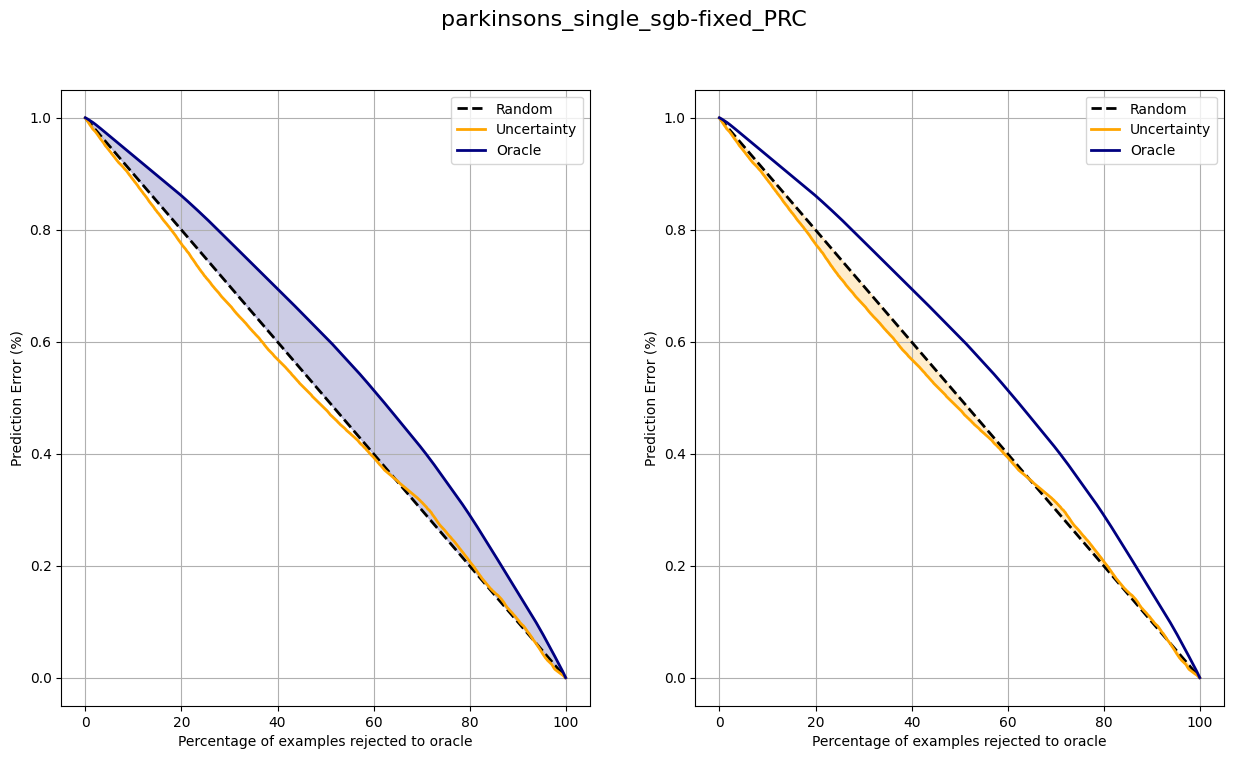

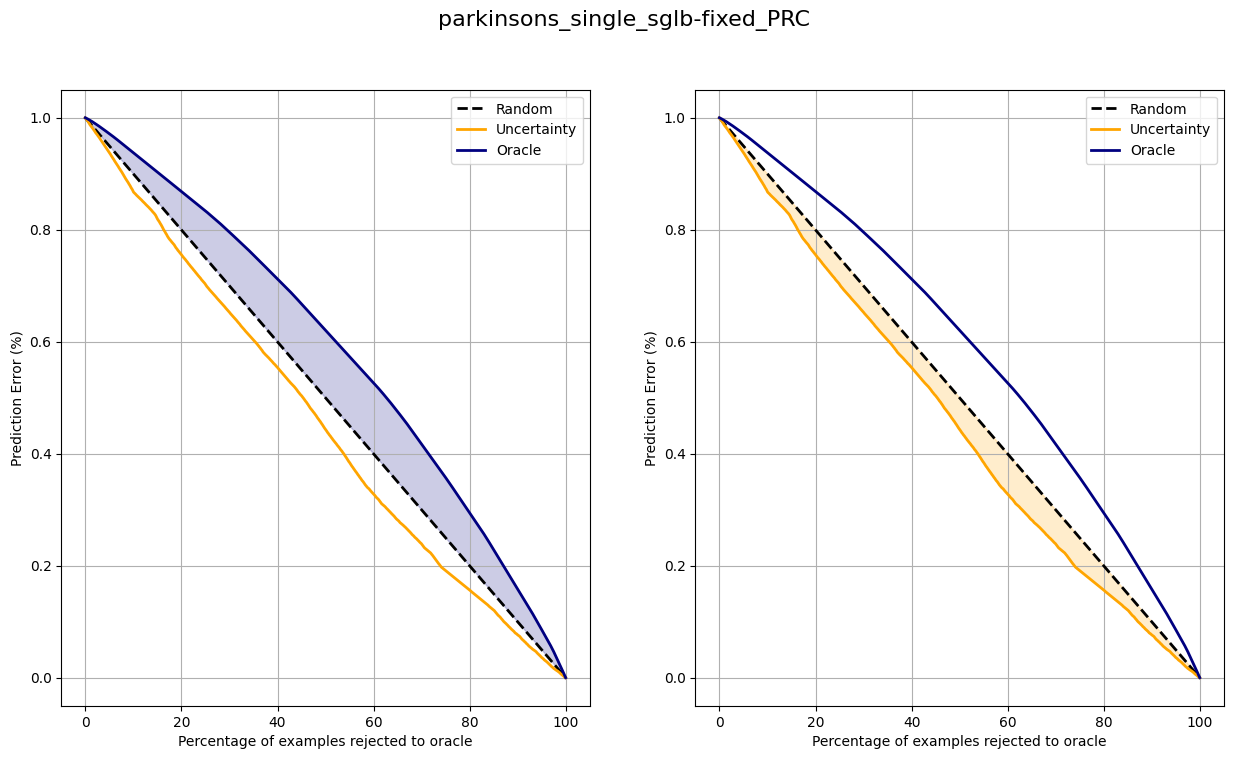

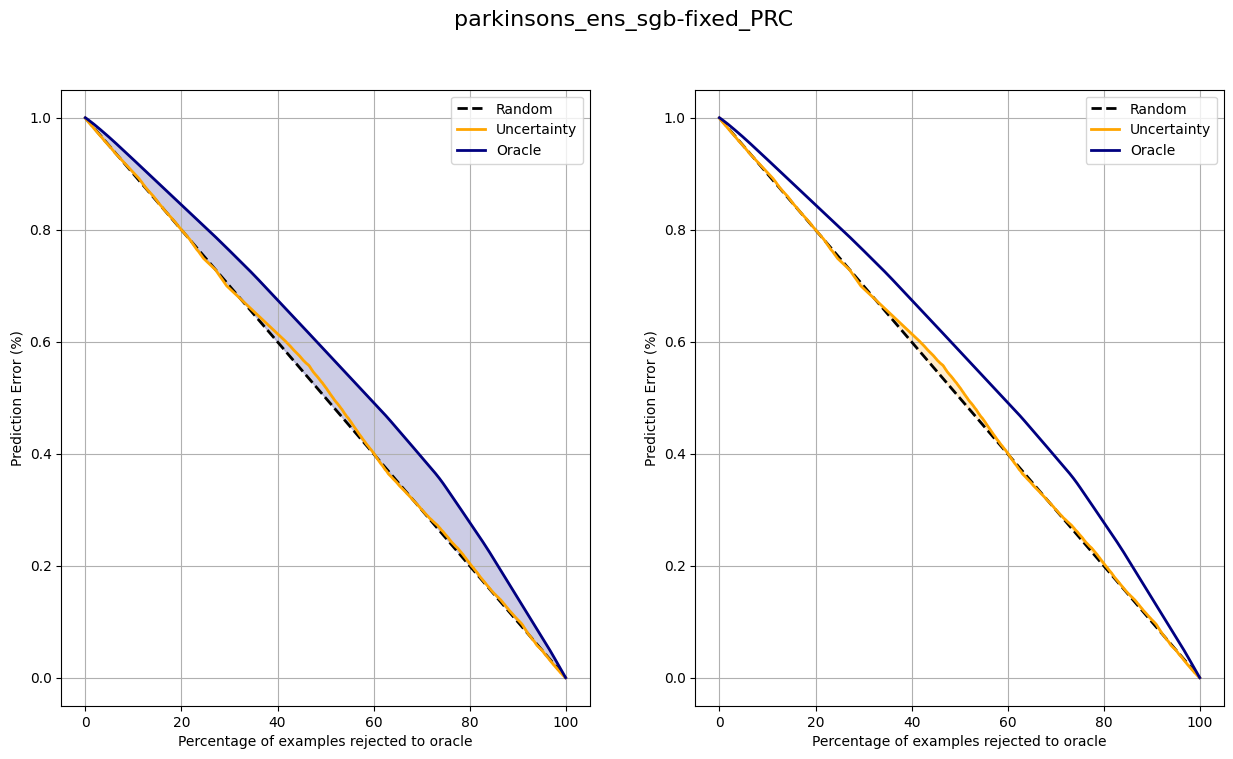

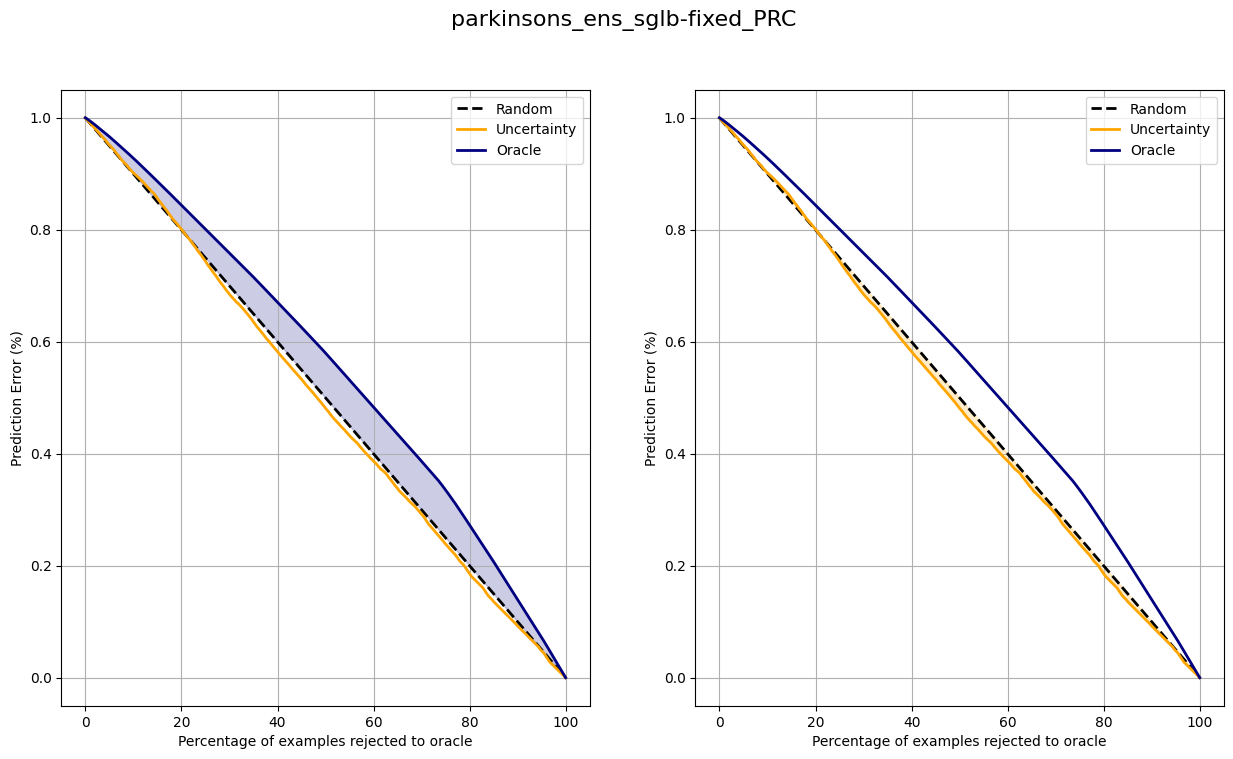

In [11]:
dataset = 'parkinsons'

print('\t\t\tRegression - Boosting')
print("\t\t\t===PRR and AUC-ROC Table===")
 
values = aggregate_results(dataset, raw=False)

make_table(values)